In [276]:
from google.colab import files
import re

import numpy as np
import pandas as pd
import sys
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [277]:
DATASET_COLUMNS = ['target', 'ids', 'date', 'flag', 'user', 'text']
DATASET_ENCODING = "ISO-8859-1"



# Load the data from the CSV file
df = pd.read_csv(r"/content/data.csv", encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

# Sample 5 rows from the resulting DataFrame
df.sample(5)


<ipython-input-277-1d2d54cdeea0>:7: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"/content/data.csv", encoding=DATASET_ENCODING, names=DATASET_COLUMNS)


,target,ids,date,flag,user,text
467254,4,1998249329,Mon Jun 01 18:14:23 PDT 2009,NO_QUERY,exit_mari,"acho q vou call it a night, comer uns damascos..."
777423,4,2188560760,Mon Jun 15 22:07:27 PDT 2009,NO_QUERY,ItsMandyYo,Shower Times Be Right Back!!
84627,4,1685004489,Sat May 02 22:44:08 PDT 2009,NO_QUERY,RocknCrs,Went to a opening of a new tattoo shop of my t...
582459,4,2051562327,Fri Jun 05 22:18:22 PDT 2009,NO_QUERY,yelhsaL,Please take me home lol
574357,4,2050360112,Fri Jun 05 18:31:48 PDT 2009,NO_QUERY,rizwandean,@Navinesh neighbors


In [278]:
df.head()

,target,ids,date,flag,user,text
0,"4""",Thu Jun 25 07:00:27 PDT 2009,NO_QUERY,tsinawhitee,@funkyfannys ahahahah! i luvs it! a frisky gra...,NaN
1,0,2326413914,Thu Jun 25 07:00:28 PDT 2009,NO_QUERY,oliviaistaken,"@KevinRuddPM hey, I have an assignment draft d..."
2,0,2326414027,Thu Jun 25 07:00:29 PDT 2009,NO_QUERY,kimbo1073,is absolutely nakerd
3,0,2326414250,Thu Jun 25 07:00:30 PDT 2009,NO_QUERY,Frogg1rl,My stomach is still punishing me
4,0,2326414355,Thu Jun 25 07:00:30 PDT 2009,NO_QUERY,MayaPosch,Gah... feeling dizzy and nauseous I think I'l...


In [279]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [280]:
print('length of data is', len(df))

length of data is 807175


In [281]:
df. shape

(807175, 6)

In [282]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807175 entries, 0 to 807174
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  807175 non-null  object
 1   ids     807175 non-null  object
 2   date    807175 non-null  object
 3   flag    807175 non-null  object
 4   user    807175 non-null  object
 5   text    807174 non-null  object
dtypes: object(6)
memory usage: 36.9+ MB


In [283]:
df.dtypes

target    object
ids       object
date      object
flag      object
user      object
text      object
dtype: object

In [284]:
np.sum(df.isnull().any(axis=1))

1

In [285]:
#Rows and columns in the dataset

print('Count of columns in the data is:  ', len(df.columns))
print('Count of rows in the data is:  ', len(df))

Count of columns in the data is:   6
Count of rows in the data is:   807175


In [286]:
#Check unique target values

df['target'].unique()

array(['4"', '0', '4', 4], dtype=object)

In [287]:
#Check the number of target values

df['target'].nunique()

4

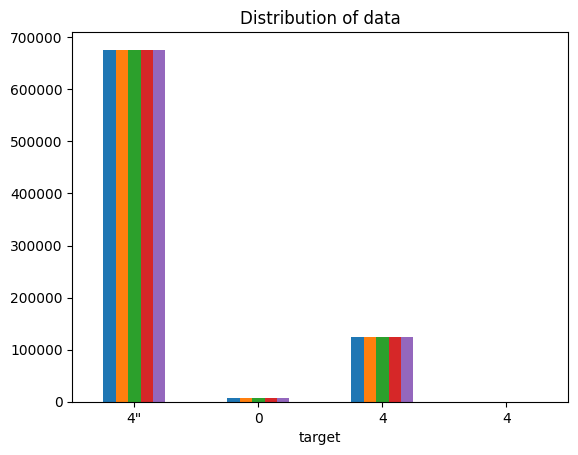

In [288]:


# Plotting the distribution for dataset
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data', legend=False)

# Get the unique target values and set them as tick labels
unique_targets = df['target'].unique()
ax.set_xticklabels(unique_targets, rotation=0)

# Storing data in lists
text, sentiment = list(df['text']), list(df['target'])

plt.show()


<Axes: xlabel='target', ylabel='count'>

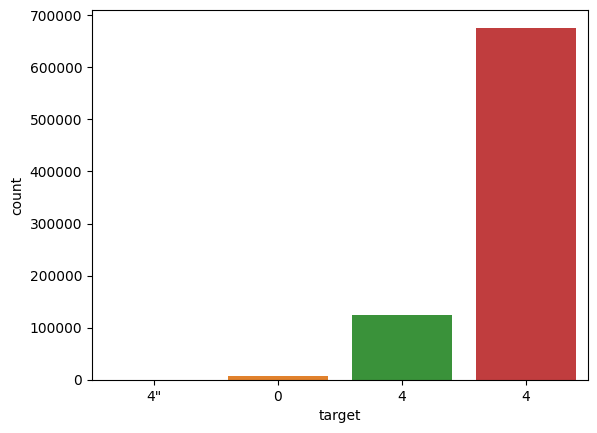

In [289]:
sns.countplot(x='target', data=df)

In [290]:
#Selecting the text and Target column for our further analysis
data=df[['text','target']]
#Replacing the values to ease understanding. (Assigning 1 to Positive sentiment 4)

data['target'] = data['target'].replace(4,1)
#Printing unique values of target variables

data['target'].unique()

<ipython-input-290-00aa45d1b3f4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


array(['4"', '0', '4', 1], dtype=object)

In [291]:
#Separating positive and negative tweets

data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]
#Taking one-fourth of the data so we can run it on our machine easily

data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]
#Combining positive and negative tweets

dataset = pd.concat([data_pos, data_neg])
#Making statement text in lowercase

dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

151067    @kimberger - yes, just one!!  can't wait for u...
151068          @schmuttelicious hey dude..!? stil there?? 
151069                        trying to figure out twitter 
151070    our god and kind-oh praise him! he is king of ...
151071    @tommcfly do a cover of beat it and change the...
Name: text, dtype: object

In [292]:
#Defining set containing all stopwords in English.

stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']
#Cleaning and removing the above stop words list from the tweet text

STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

131072    @erwanmace first turned 3.0b1 gave no options ...
131073                             @makzan pretty much day.
131074                               @laurawalkerxo, sweet!
131075    lol. songs though. i'm like weird al, but less...
131076    @natyygiirlx33 hey girl!! happy mothers day 2 ...
Name: text, dtype: object

In [293]:
#Cleaning and removing punctuations

import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

151067    kimberger  yes one cant wait u meet her httpyf...
151068                  schmuttelicious hey dude stil there
151069                                trying figure twitter
151070      god kindoh praise him king all  httpblipfm69e2x
151071        tommcfly cover beat change words beat tweet x
Name: text, dtype: object

In [294]:
#Cleaning and removing repeating characters

def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

151067    kimberger  yes one cant wait u meet her httpyf...
151068                  schmuttelicious hey dude stil there
151069                                trying figure twitter
151070      god kindoh praise him king all  httpblipfm69e2x
151071        tommcfly cover beat change words beat tweet x
Name: text, dtype: object

In [295]:
#Cleaning and removing URLs

def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

151067    kimberger  yes one cant wait u meet her httpyf...
151068                  schmuttelicious hey dude stil there
151069                                trying figure twitter
151070      god kindoh praise him king all  httpblipfm69e2x
151071        tommcfly cover beat change words beat tweet x
Name: text, dtype: object

In [296]:
#Cleaning and removing numeric numbers

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

151067    kimberger  yes one cant wait u meet her httpyf...
151068                  schmuttelicious hey dude stil there
151069                                trying figure twitter
151070         god kindoh praise him king all  httpblipfmex
151071        tommcfly cover beat change words beat tweet x
Name: text, dtype: object

In [297]:
#Getting tokenization of tweet text

from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

131072    [w, w, w]
131073           []
131074       [w, w]
131075          [w]
131076          [w]
Name: text, dtype: object

In [298]:
#Applying stemming

import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

131072    [w, w, w]
131073           []
131074       [w, w]
131075          [w]
131076          [w]
Name: text, dtype: object

In [299]:
#Applying lemmatizer

lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

131072    [w, w, w]
131073           []
131074       [w, w]
131075          [w]
131076          [w]
Name: text, dtype: object

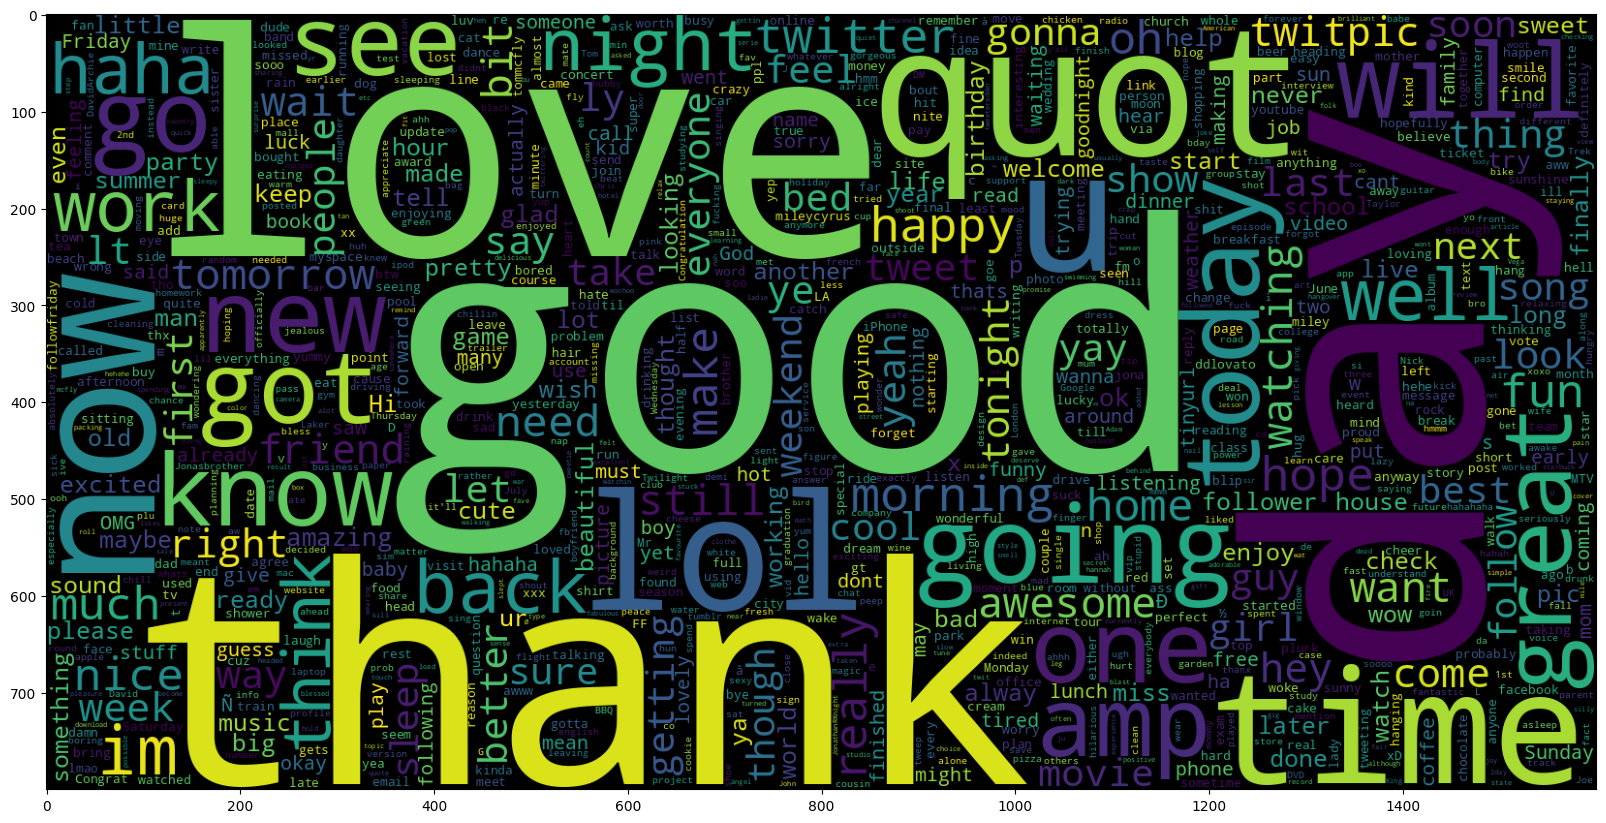

In [300]:

# Separating input feature and label
X = data['text']
y = data['target']

# Filter out non-string values from 'data_neg'
data_neg = data['text'][:800000].apply(str)

plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)
plt.show()


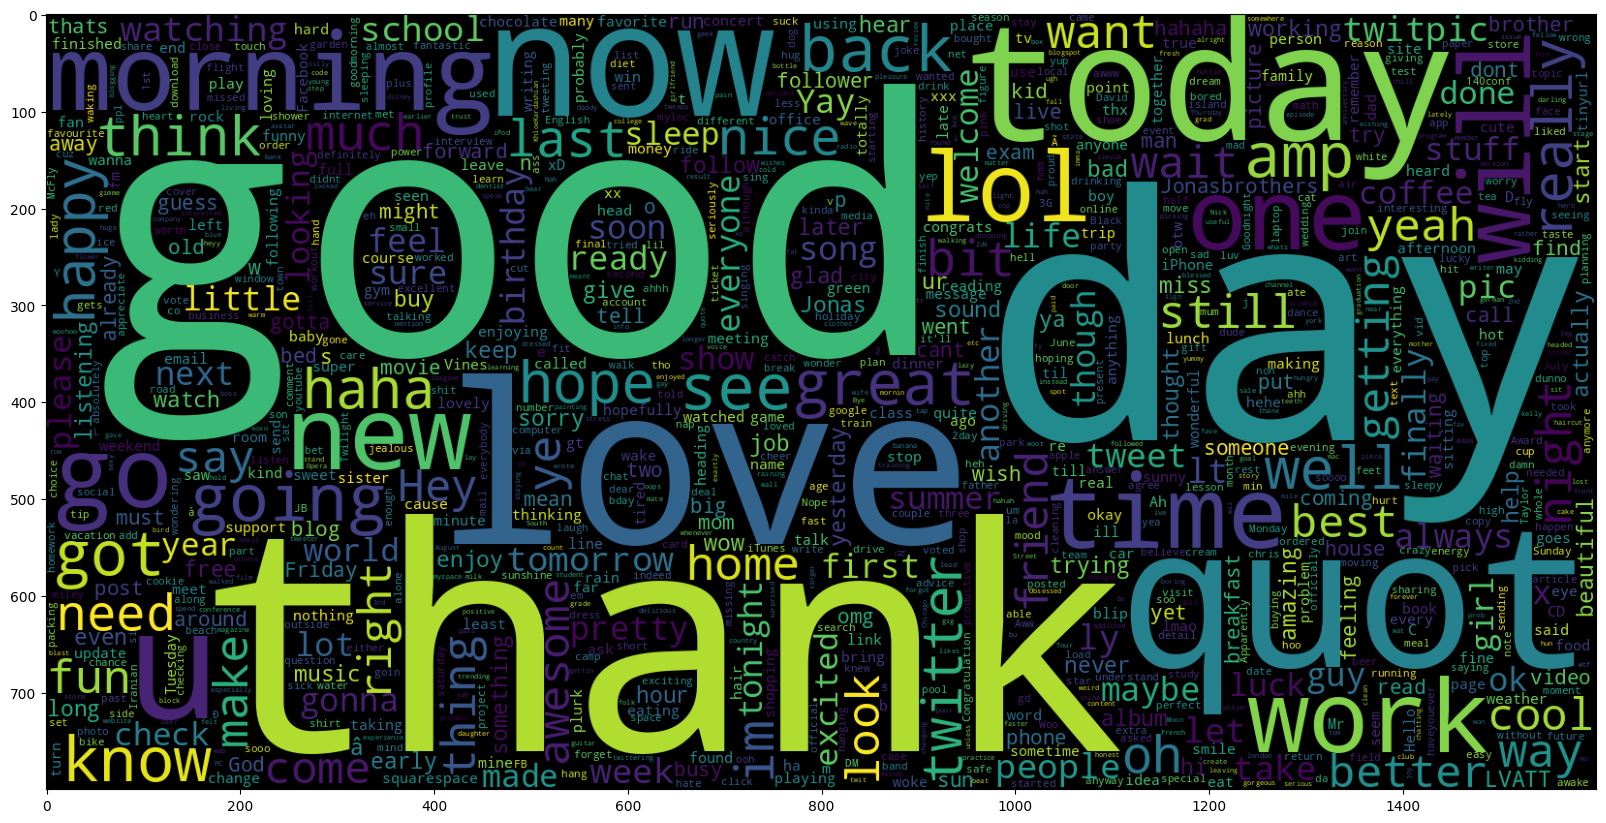

In [301]:
#Plot a cloud of words for positive tweets

data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [302]:



# Assuming you have a DataFrame 'data' with 'X' and 'y' columns

# Remove rows with NaN values from the DataFrame
data = data.dropna()

# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], test_size=0.05, random_state=26105111)
X_train = X_train.str.lower()
X_test = X_test.str.lower()
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
vectorizer.fit(X_train)
print('No. of feature_words:', len(vectorizer.get_feature_names_out()))

No. of feature_words: 500000


In [303]:


# Transform the training and test data
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [304]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative', 'Positive']
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='',
                xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)


In [305]:
from sklearn.preprocessing import LabelEncoder
# Convert labels to strings
y_train = y_train.astype(str)
y_test = y_test.astype(str)


label_encoder = LabelEncoder()

# Now, you can apply the LabelEncoder
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)


              precision    recall  f1-score   support

           0       1.00      0.00      0.01       346
           1       0.84      0.96      0.90     33752
           2       0.33      0.10      0.15      6261

    accuracy                           0.82     40359
   macro avg       0.72      0.35      0.35     40359
weighted avg       0.77      0.82      0.78     40359



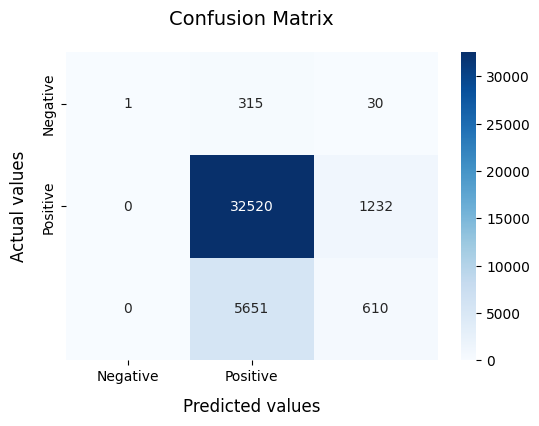

In [306]:


def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative', 'Positive']

    plt.figure(figsize=(6, 4))
    sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=categories, yticklabels=categories)

    plt.xlabel("Predicted values", fontdict={'size': 12}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 12}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 14}, pad=20)
    plt.show()

# Call the function to evaluate your model
model_Evaluate(BNBmodel)


Overall ROC AUC (OvR): 0.68


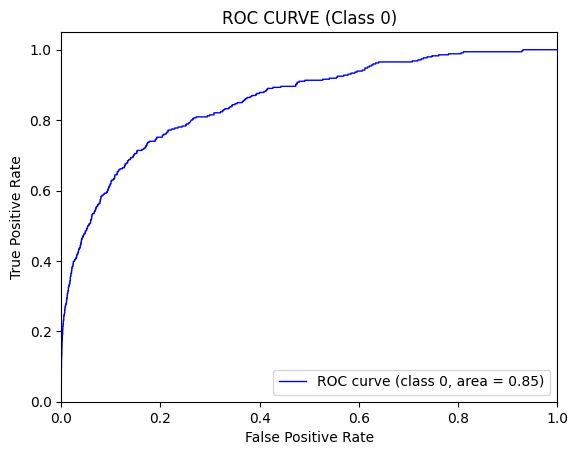

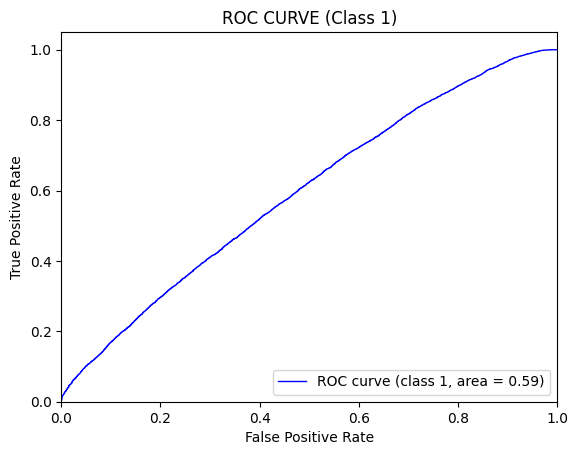

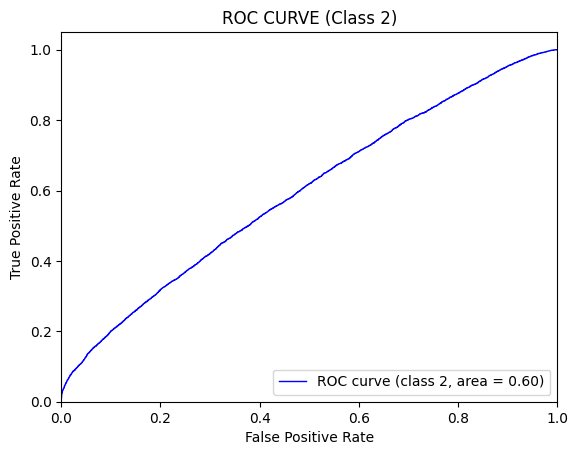

In [308]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

n_classes = len(np.unique(y_test))
roc_auc_scores = []

for class_index in range(n_classes):
    y_true_binary = [1 if label == class_index else 0 for label in y_test]
    roc_auc = roc_auc_score(y_true_binary, y_pred_probs[:, class_index])
    roc_auc_scores.append(roc_auc)

    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_probs[:, class_index])
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=1, label=f'ROC curve (class {class_index}, area = {roc_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC CURVE (Class {class_index})')
    plt.legend(loc="lower right")

overall_roc_auc = sum(roc_auc_scores) / n_classes
print(f"Overall ROC AUC (OvR): {overall_roc_auc:.2f}")

plt.show()


              precision    recall  f1-score   support

           0       0.83      0.10      0.18       346
           1       0.85      0.97      0.91     33752
           2       0.39      0.09      0.14      6261

    accuracy                           0.83     40359
   macro avg       0.69      0.39      0.41     40359
weighted avg       0.78      0.83      0.78     40359



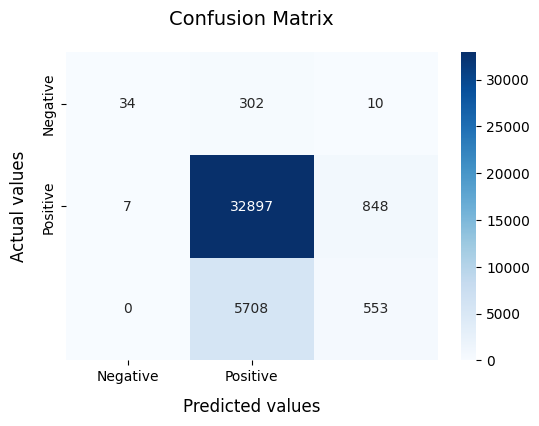

In [309]:
#Model-2:

SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

Overall ROC AUC (OvR): 0.68


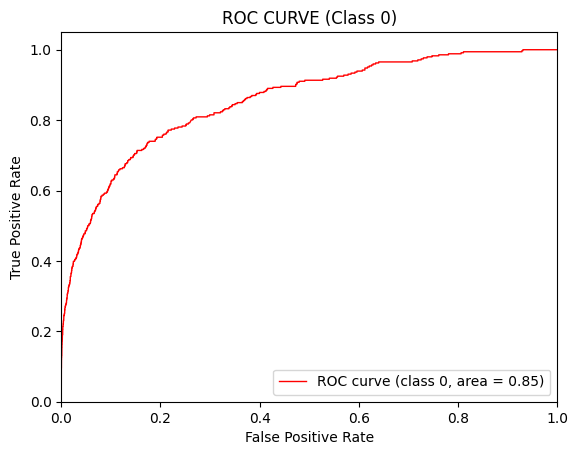

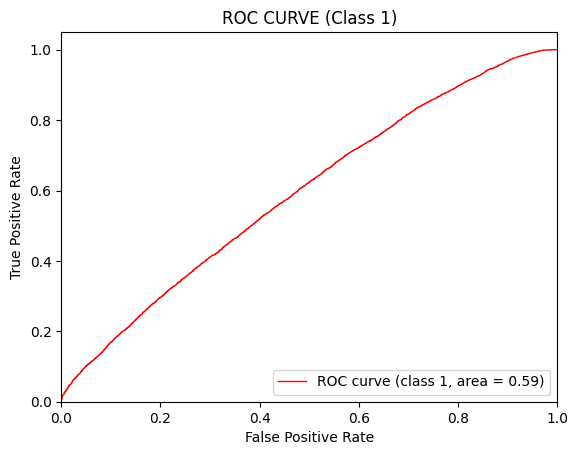

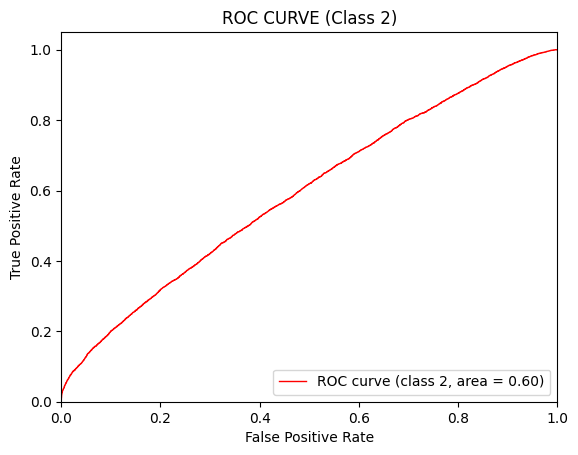

In [310]:
#Plot the ROC-AUC Curve for model-2


# Get the number of unique classes
n_classes = len(np.unique(y_test))

# Initialize a list to store ROC AUC scores for each class
roc_auc_scores = []

# Initialize a list to store the predicted probabilities
y_pred_probs = SVCmodel.decision_function(X_test)

# Iterate through each class
for class_index in range(n_classes):
    # Create binary labels for the current class
    y_true_binary = [1 if label == class_index else 0 for label in y_test]

    # Calculate ROC AUC for the current class
    roc_auc = roc_auc_score(y_true_binary, y_pred_probs[:, class_index])
    roc_auc_scores.append(roc_auc)

    # Plot the ROC curve for the current class
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_probs[:, class_index])
    plt.figure()
    plt.plot(fpr, tpr, color='red', lw=1, label=f'ROC curve (class {class_index}, area = {roc_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC CURVE (Class {class_index})')
    plt.legend(loc="lower right")

# Overall ROC AUC (average of individual class AUCs)
overall_roc_auc = sum(roc_auc_scores) / n_classes
print(f"Overall ROC AUC (OvR): {overall_roc_auc:.2f}")

plt.show()


**Model Evaluation
Upon evaluating all the models, we can conclude the following details i.e.

Accuracy: As far as the accuracy of the model is concerned, n SVM, performs better than Bernoulli Naive Bayes.**